In [66]:
import numpy as np
import matplotlib.pyplot as plt

from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Sequence, Dict, Tuple
from scipy.stats import lognorm
from numpy.linalg import solve
from numba import njit

import importlib
# --- Core code helpers ---
import src.core_helpers
importlib.reload(src.core_helpers)
from src.core_helpers import *

# --- Core Synthetic data ---
import src.core_SynData
importlib.reload(src.core_SynData)
from src.core_SynData import *

# --- Solvers ---
import src.core_Solvers
importlib.reload(src.core_Solvers)
from src.core_Solvers import *

# --- Figures ---
import src.core_Figures
importlib.reload(src.core_Figures)
from src.core_Figures import *

# --- Parametric moments ---
import src.core_Moments
importlib.reload(src.core_Moments)
from src.core_Moments import *

# --- Energy Solvers ---
import src.core_ESolvers
importlib.reload(src.core_ESolvers)
from src.core_ESolvers import *

#### VKU $P_{max}$ - $\beta$ relationship

In [2]:
VKU_Pmax = 126      # [MW]
VKU_beta_GL = 0.6196
VKU_beta_SL = 0.7157
s_ratio = (1/VKU_beta_SL) / VKU_Pmax
print(f"s_ratio: {s_ratio}")

s_ratio: 0.011089154585032747


### Simulation Parameters

In [3]:
# --- Simulation Parameters ---
N = 100000000
grid = 1001
r = 0.01*60                 # 1/HR
tau = 0.0 
dt = 1/60                   # 1/HR
beta = 0.6               # min/MW
Pmax = (1/beta)/s_ratio
alpha = r*Pmax           # MW/HR]

a = alpha * dt           # MW
a_tilde = beta * a
print(f"Pmax: {Pmax}")
print(f"alpha value: {alpha} \na value: {a} \na_tilde value: {a_tilde}")

# --- Parameters for infinity limit ---
Pmax_inf = 10000000

# --- Simulation grid for P99 figures ---
r_values = np.linspace(0.1, 3.5, 50) / (beta * Pmax)    # [1/MIN]
alpha_values = r_values*60*Pmax                       # [MW/HR] (ALPHA)
a_values = alpha_values * dt                          # [MW/MIN]
a_tilde_values = beta * a_values
print(f"min(alpha_values): {min(alpha_values)}, max(alpha_values): {max(alpha_values)}")
print(f"min(a_values): {min(a_values)}, max(alpha_values): {max(a_values)}")
print(f"min(a_values): {min(a_tilde_values)}, max(a_values): {max(a_tilde_values)}")

Pmax: 150.297
alpha value: 90.17819999999999 
a value: 1.50297 
a_tilde value: 0.9017819999999999
min(alpha_values): 10.000000000000002, max(alpha_values): 350.00000000000006
min(a_values): 0.16666666666666669, max(alpha_values): 5.833333333333334
min(a_values): 0.1, max(a_values): 3.5000000000000004


### Synthetic Data

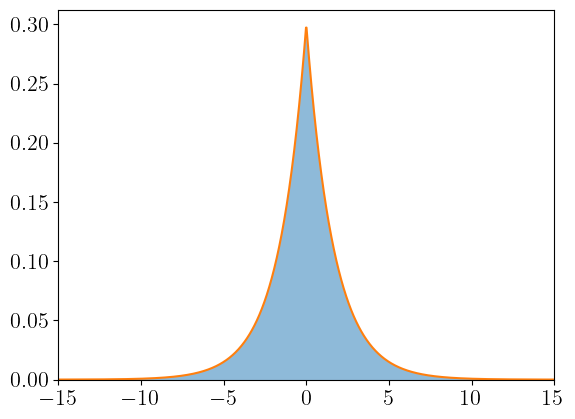

In [4]:
# --- SIMPLE LAPLACE TIME SERIES ---
rng = np.random.default_rng(7)
seed = rng.random(N)
Y, P = simulate_Y_P_SL(N, Pmax, 55, beta, seed)

# --- Taking P0 -> infinity ---
rng = np.random.default_rng(7)
seed = rng.random(N)
Y_inf, P_inf = simulate_Y_P_SL(N, Pmax_inf, 55, beta, seed)


x = np.linspace(-15, 15, 1000)
Y_analytical = 0.5*beta * np.exp(-np.abs(x)*beta)
plt.figure()
plt.hist(Y_inf, bins=1000, density=True, alpha=0.5, label='Y_inf')
plt.plot(x, Y_analytical, label='Analytical')
plt.xlim(-15, 15)
plt.show()

### Energy ramps: Simulation

Number of ramps: {13708072}


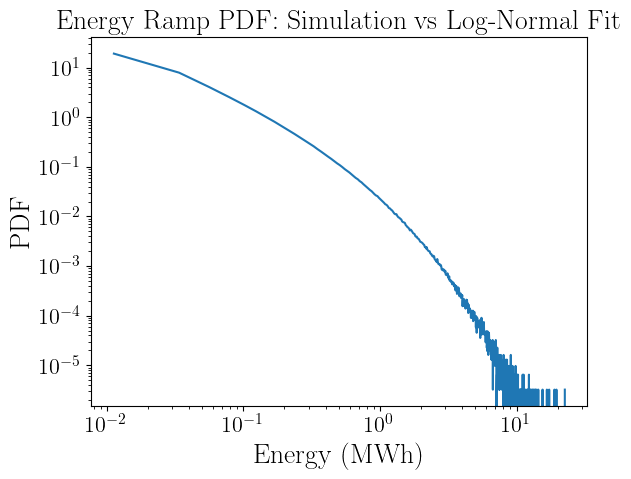

In [ ]:
energies, e_sim, f_sim, p99_sim = E_algorithmic_solution(a, Y_inf, dt, grid, q=0.99)
print("Number of ramps:", {len(energies)})
plt.figure()
plt.plot(e_sim, f_sim, label='Simulated PDF')
plt.title("Energy Ramp PDF: Simulation vs Log-Normal Fit")
plt.xlabel("Energy (MWh)")
plt.ylabel("PDF")
plt.xscale("log")
plt.yscale("log")
plt.show()

### Conditional and Global moments

In [39]:
# Build Nyström matrices I, K and z_grid
z_max = 40.0
I, K, z_grid, w, h = Nystrom(
    z_max=z_max,
    N=grid,
    kernel_pdf=lambda delta: f_X(delta, beta=beta, a=a),    # delta = b_j - z_i
)

# CONDITIONAL MOMENTS CALCULATION
m1 = solve(I - K, dt * z_grid)
m2 = solve(I - K, 2.0 * dt * z_grid * m1 - (dt * z_grid) ** 2)

# ENTRANCE MIXTURE: GLOBAL MOMENTS
Ppos = 1.0 - F_X(0.0, beta=beta, a=a)
pdf_grid = f_X(z_grid, beta=beta, a=a)

E1 = GM_mix(m1, w, h, pdf_grid, Ppos)
E2 = GM_mix(m2, w, h, pdf_grid, Ppos)

print("Moments:")
print(f"E[E]   = {E1:.6f}")
print(f"E[E^2] = {E2:.6f}")

Moments:
E[E]   = 0.097417
E[E^2] = 0.062685


### Log-normal fit

In [71]:
@dataclass(frozen=True)
class LogNormParams:
    mu: float
    sigma: float  # > 0
    scale: float  # exp(mu)
    e_grid: None[np.ndarray]
    
LN_params, LN_pdf, LN_cdf = E_LogNorm_solution(e_sim, energies, E1, E2, 1000000)

### Comparition: LogNormal fit vs Simulation

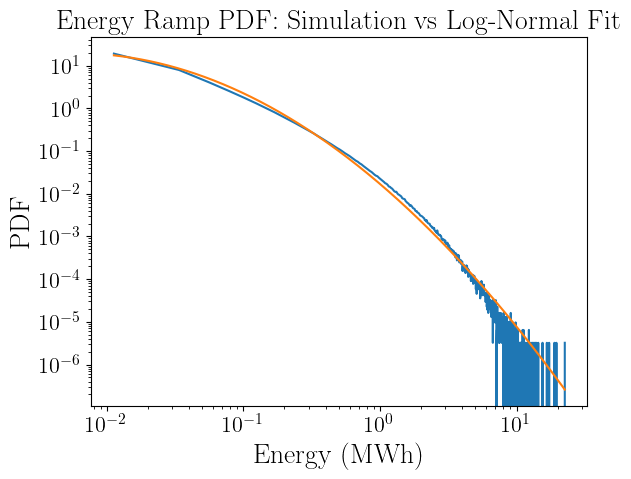

In [72]:
plt.figure()
plt.plot(e_sim, f_sim, label='Simulated PDF')
plt.plot(LN_params.e_grid, LN_pdf, label='Log-Normal Fit', linewidth=1.5)
plt.title("Energy Ramp PDF: Simulation vs Log-Normal Fit")
plt.xlabel("Energy (MWh)")
plt.ylabel("PDF")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [58]:
min(e_sim)

np.float64(0.011276499515702218)